**Introduction to Applications of Quantum Computing to Quan-
tum Chemistry**

2.   **Ground state energy for molecule and spin system with Variational
Quantum Algorithms and Trotterization.**

Variational Quantum Algorithms (VQAs) are a class of hybrid quantum-classical algorithms. These algorithms leverage quantum circuits to accelerate computations while utilizing a classical optimizer to iteratively adjust the parameters of the circuit, seeking to minimize a cost function and ultimately find the correct solution.

(a) The calculation of molecular properties is crucial in scientific and technological fields, such as chemistry and the pharmaceutical industry. In particular, the ground state energy of a molecule provides valuable insights into its properties, including stability and reactivity.

You must implement a function in Pennylane that simulates the Variational Quantum Eigensolver (VQE). This function should take as input a six-entry array of floating-point numbers, representing the x, y and z coordinates of two hydrogen atoms. The first three entries correspond to the coordinates of the first hydrogen atom, and the remaining three entries represent the coordinates of the second hydrogen atom. The function should return the ground state energy of the molecule. Also explain why the Pauli-Z is necessary in Jordan-Wigner transformation.

**Observation: Explicitly define the STO-3G basis function set, multiplicity=1, charge=0 and Jordan-Wigner mapping in the code.**

(b) Consider a spin chain consisting of N spin-$\frac{1}{2}$
particles, where each spin can point either in the positive or negative z-direction. Additionally, an external magnetic field is applied to the system.

This quantum system is described by the Transverse Ising Hamiltonian. For a closed spin chain with a transverse magnetic field of intensity h, the Hamiltonian is:

$$ H = -\sum_{i=1}^N Z_i \otimes Z_{i+1} -h\sum_{n=1}^NX_i$$
where $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X operators acting on the $i-th$ spin site, respectively. In a closed chain, the site $N + 1$ is identified with the first site.

You must implement a variational quantum algorithm in Pennylane that, for a given value of the transverse magnetic field h, computes the ground state energy of the spin chain with N = 4 sites. The magnetic field intensity h should be passed as an input to the algorithm.

(c) The total energy of a quantum system is represented by operator $H$. We know
that an initial quantum state $|\psi⟩$ evolves over time through the action of the evolution operator U, defined as

$$ U(t) = e^{-iHt} $$

However, it’s possible to build quantum circuits that approximates the realization of
$U(t)$, being one of these methods knows as Trotterization. If we can write $H$ as

$$ H = \sum_{i=0}^kH_i, $$
of a number $k$ of Hermitian operators $H_i$ that do not necessarily commute, we can approximate $U(t)$ via

$$U \approx ∏_{j=1}^n∏_{i=1}^ke^{\frac{-iH_it}{n}}, $$
with each term in the j-product called trotter step. The larger n is, i.e. more trotter
steps, the better the approximation of U that we get.

You must implement in Pennylane a function which applies the evolution operator
related to the Hamiltonian

$$H = αX⊗X + βZ⊗Z$$
in the state $|00⟩$. The function must receive as parameters α, β, the time t and the number
of trotter steps n in this order. It must return the probability of measure $|00⟩, |01⟩, |10⟩, |11⟩$.

In [3]:
!pip install pennylane

import pennylane as qml
from pennylane import numpy as pnp
import scipy as sci

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.7 MB/s eta 0:00:00


In [47]:
# Question (a)

def H2_molecule():

  '''
  This function returns the ground state of the H2 molecule.

  Enter the coordinates of the Hydrogen atoms as x, y, and z values separated by
  spaces.

  The function computes the ground state using a VQA with Hartree Fock initial
  state, a Double Excitation circuit ansatz and a Gradient Descent optimizer.
  '''

  # Collect the coordinates
  coord_1 = list(map(float, input('Enter the coordinates of the first H as x y z: ').split()))
  coord_2 = list(map(float, input('Enter the coordinates of the second H as x y z: ').split()))

  # Define the symbols and the coordinates
  symbols = ["H", "H"]
  coordinates = pnp.array([coord_1, coord_2])

  # Create the molecule
  molecule = qml.qchem.Molecule(symbols, coordinates, charge = 0, mult = 1, basis_name='sto-3g') # Creating the molecule with the exercise
  H, qubits = qml.qchem.molecular_hamiltonian(molecule, mapping='jordan_wigner')

  # Print out the Hamiltonian just to check if it's all right
  print(f"Hamiltonian: {H}")

  # Connecting  with the device
  dev = qml.device("default.qubit", wires = qubits)

  # Creating the cost_function
  @qml.qnode(dev)
  def cost_function(params): # What is this params?
    qml.BasisState(pnp.array([1, 1, 0, 0]), wires = range(qubits)) # Creating the basis state
    qml.DoubleExcitation(params, wires = [0, 1, 2, 3]) # Why i have to use Double Exctations?

    return qml.expval(H)

  # Choose an optimizer
  opt = qml.GradientDescentOptimizer(stepsize = 0.4)

  # Initial guess parameters
  theta = pnp.array(0.20885146442480412, requires_grad=True)

  # Programing the optimzation routine
  energy = [cost_function(theta)] # Store the values of the cost function
  angle = [theta] # Store the values of the circuit parameter

  max_iterations = 40 # Maximum number of calls to the optimizer
  conv_tol = 1e-06 # Convergence threshold to stop our optimization procedure

  for n in range(max_iterations):
    theta,prev_energy=opt.step_and_cost(cost_function,theta)
    energy.append(cost_function(theta))
    angle.append(theta)
    conv=pnp.abs(energy[-1]-prev_energy)

    if conv<=conv_tol:
        break

  # Print out the value of the ground state energy
  print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")

  # Drawing the circuit
  print("\nVisualing the circuit:")
  qml.draw_mpl(cost_function)(1);

  return ''

Enter the coordinates of the first H as x y z: 0 0 0.64
Enter the coordinates of the second H as x y z: 0 0 -0.64
Hamiltonian: -0.007563802712883733 * I(0) + 0.18141527677493247 * Z(0) + 0.18141527677493235 * Z(1) + 0.17167671397485101 * (Z(0) @ Z(1)) + -0.25446179393375096 * Z(2) + 0.12424794036376924 * (Z(0) @ Z(2)) + 0.16869146530747586 * (Z(1) @ Z(2)) + 0.04444352494370666 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04444352494370666 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04444352494370666 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04444352494370666 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.254461793933751 * Z(3) + 0.16869146530747586 * (Z(0) @ Z(3)) + 0.12424794036376924 * (Z(1) @ Z(3)) + 0.1773513117131797 * (Z(2) @ Z(3))

Final value of the ground-state energy = -1.13411023 Ha

Visualing the circuit:




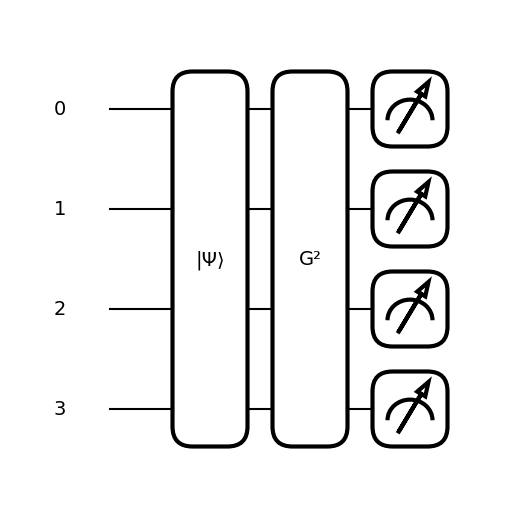

In [44]:
print(H2_molecule())

In [40]:
# Question (b)

def Ising_Model():
  '''
  This function calculates the ground state of a spin chain using the Transverse
  Ising Hamiltonian.

  Input the magnetic field intensity only. It computes the ground state for 4
  qubits with a VQA model, starting from |1,1,0,0> as the initial state,
  employing X and Z axis rotations as the ansatz and using a Gradient Descent
  optimizer.
  '''

  # Geting the h value
  h = float(input("Enter the extenal magnetic field: "))

  # Creating the Hamiltonian
  coefs = [-1, -h]
  ops = [sum(qml.PauliZ(i) @ qml.PauliZ(i+1) for i in range(1,4)) + qml.PauliZ(4) @ qml.PauliZ(1), sum(qml.PauliX(i) for i in range(1, 5))]
  H = qml.Hamiltonian(coefs, ops)

  # Printing the Hamltonian
  print(f"\nThe Hamiltonian is given by: {H}")

  # Creating the circuit
  dev = qml.device("default.qubit")
  @qml.qnode(dev)
  def cost_function(params):
    # Build the initial state
    qml.BasisState(pnp.array([1, 1, 0, 0]), wires = range(1, 5))
    # Applying rotation as an ansatz
    for i in range(1,5):
      qml.RX(params, wires = i)
      qml.RZ(params, wires = i)
    return qml.expval(H)

  # Choose an optimizer
  opt = qml.GradientDescentOptimizer(stepsize = 0.1)

  # Initial guess parameters
  theta = pnp.array(0.5, requires_grad=True)

  # Programing the optimzation routine
  energy = [cost_function(theta)] # Store the values of the cost function
  angle = [theta] # Store the values of the circuit parameter

  max_iterations = 40 # Maximum number of calls to the optimizer
  conv_tol = 1e-06 # Convergence threshold to stop our optimization procedure

  for n in range(max_iterations):
    theta,prev_energy=opt.step_and_cost(cost_function,theta)
    energy.append(cost_function(theta))
    angle.append(theta)
    conv=pnp.abs(energy[-1]-prev_energy)

    if conv<=conv_tol:
      break

  # Print out the value of the ground state energy
  print(f"\nFinal value of the ground-state energy = {energy[-1]:.6f} Ha")

  print("\nVisualizing the circuit:")

  qml.draw_mpl(cost_function)(1);

  return ''

Enter the extenal magnetic field: 0.1

The Hamiltonian is given by: -1 * (Z(1) @ Z(2) + Z(2) @ Z(3) + Z(3) @ Z(4) + Z(4) @ Z(1)) + -0.1 * (X(1) + X(2) + X(3) + X(4))

Final value of the ground-state energy = 0.000000 Ha
Visualizing the circuit:



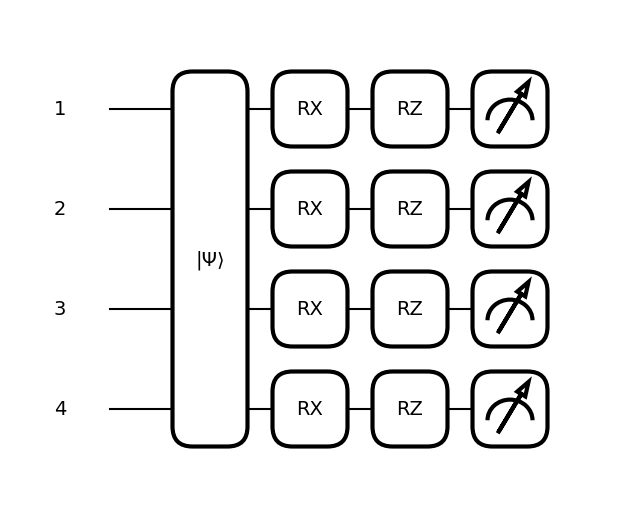

In [45]:
print(Ising_Model())

In [48]:
# Question (c)

def Time_Evolution():
  '''
  This function calculates the probability of states |0,0>, |0,1>, |1,0>, and
  |1,1> after time evolution at time t using the Trotterization method.

  The user inputs parameters a, b, the number of Trotter steps n, and time t.
  It utilizes a specified Hamiltonian H, starting from the initial state |0,0>,
  and applies Ising operators to compute time evolution and return the
  probabilities.
  '''

  # Reciving the parameters
  alpha = float(input("Enter the value of alpha: "))
  beta = float(input("Enter the value of beta: "))
  n = int(input("Enter the value of n: "))
  t = float(input("Enter the value of t: "))

  # Building the Hamiltonian
  coefs = [alpha, beta]
  ops = [qml.PauliX(0) @ qml.PauliX(1), qml.PauliZ(0) @ qml.PauliZ(1)]

  H = qml.Hamiltonian(coefs, ops)

  print(f"\nThe Hamiltonian is given by: {H}")

  # Creating the circuit
  wires = range(2)
  @qml.qnode(dev)
  def circuit(time, n):
    qml.BasisState(pnp.array([0, 0]), wires = range(2))
    for i in range(n):
      qml.IsingXX(2*alpha*time/n, wires = [0,1])
      qml.IsingZZ(2*beta*time/n, wires = [0,1])

    return qml.probs(wires = [0,1])

  # Printing the answers

  print("\nProbabilitys for ours function:")
  print(f"\nThe probability of measure |00⟩ is: {circuit(t,n)[0]*100:.5f}%")
  print(f"The probability of measure |01⟩ is: {circuit(t,n)[1]*100:.5f}%")
  print(f"The probability of measure |10⟩ is: {circuit(t,n)[2]*100:.5f}%")
  print(f"The probability of measure |11⟩ is: {circuit(t,n)[3]*100:.5f}%\n")

  print("Visualizing the circuit:")

  qml.draw_mpl(circuit)(1,1);

  return ''


Enter the value of alpha: 1
Enter the value of beta: 1
Enter the value of n: 100
Enter the value of t: 5

The Hamiltonian is given by: 1.0 * (X(0) @ X(1)) + 1.0 * (Z(0) @ Z(1))

Probabilitys for ours function:

The probability of measure |00⟩ is: 8.04642%
The probability of measure |01⟩ is: 0.00000%
The probability of measure |10⟩ is: 0.00000%
The probability of measure |11⟩ is: 91.95358%

Visualizing the circuit:



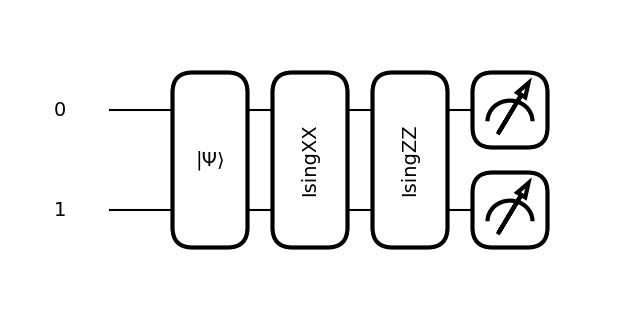

In [49]:
print(Time_Evolution())